# LV3 - Klasifikacija teksta pomoću strojnog učenja



## Ciljevi laboratorijske vježbe:


*   Pripremiti označene skupove podataka za klasifikaciju teksta
*   Trenirati klasifikator
*   Evaluirati performanse klasifikatora (točnost, preciznost, odziv)



## 1. Instalacija biblioteka

In [ ]:
from google.colab import files
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
import re
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline

## 2. Učitavanje dataseta Coronavirus tweets NLP - Text Classification

Potrebno je preuzeti javni dataset s platforme Kaggle. Kako bi preuzimanje bilo uspješno, potrebno je preuzeti datoteku `kaggle.json` sa svog Kaggle korisničkog profila i uploadati ju prilikom izvođenja sljedećeg programskog koda. Moguće je i preuzeti dataset i prenijeti ga u Google Colab ručno. Dataset možete preuzeti na [linku](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification).



In [ ]:
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle
!kaggle datasets download -d datatattle/covid-19-nlp-text-classification

KeyboardInterrupt: 

In [ ]:
!unzip covid-19-nlp-text-classification.zip -d covid_dataset

# Ovaj dataset dolazi kodiran u ISO-8859-1 (Latin-1), pa je potrebno specificirati encoding parametar
train = pd.read_csv("sample_data/Corona_NLP_train.csv", encoding="latin1")
test = pd.read_csv("sample_data/Corona_NLP_test.csv", encoding="latin1")

train.head()

unzip:  cannot find or open covid-19-nlp-text-classification.zip, covid-19-nlp-text-classification.zip.zip or covid-19-nlp-text-classification.zip.ZIP.


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## 3. Priprema podataka



### a) Odabir značajki

In [ ]:
selected_features_train = train[['OriginalTweet', 'Sentiment']]
selected_features_test = test[['OriginalTweet', 'Sentiment']]

### b) Provjera nedostajućih vrijednosti

In [ ]:
print(selected_features_train.shape[0])
print(f"Broj nedostajućih vrijednosti:\n{selected_features_train.isnull().sum()}")

41157
Broj nedostajućih vrijednosti:
OriginalTweet    0
Sentiment        0
dtype: int64


Budući da stupac Location neće biti korišten pri treniranju modela, nedostajuće vrijednosti se mogu zanemariti.

In [ ]:
# ZADATAK: Provjerite nedostajuće vrijednosti u testnom skupu te riješite na prikladan način ukoliko ih ima
print(f"Broj nedostajućih vrijednosti:\n{selected_features_test.isnull().sum()}")

Broj nedostajućih vrijednosti:
OriginalTweet    0
Sentiment        0
dtype: int64


Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64


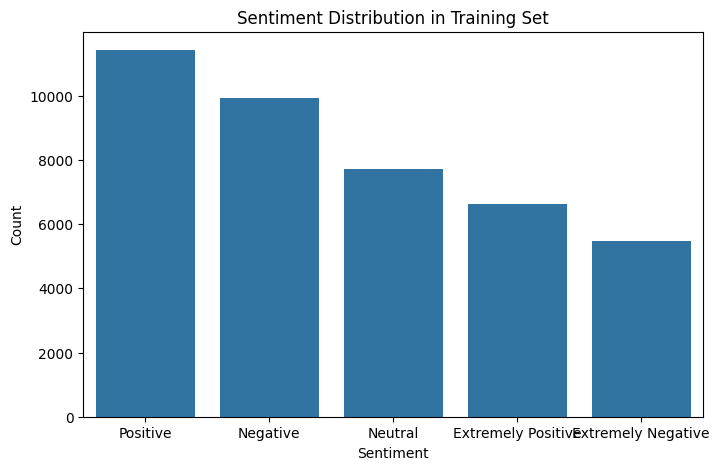

Sentiment
Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: count, dtype: int64


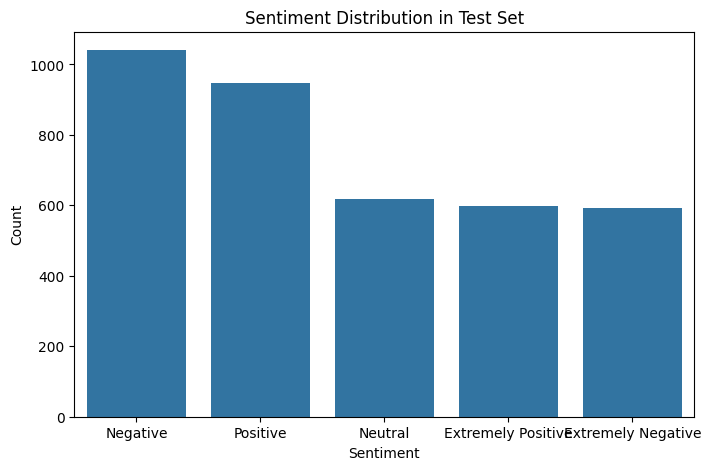

In [ ]:
#ZADATAK: Provjerite broj ponavljanja svake od kategorija tweetova te ih prikžite na grafu koristeći prikladne biblioteke

print(selected_features_train['Sentiment'].value_counts())
plt.figure(figsize=(8, 5))
sns.barplot(x=selected_features_train['Sentiment'].value_counts().index, y=selected_features_train['Sentiment'].value_counts().values)
plt.title('Sentiment Distribution in Training Set')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

print(selected_features_test['Sentiment'].value_counts())
plt.figure(figsize=(8, 5))
sns.barplot(x=selected_features_test['Sentiment'].value_counts().index, y=selected_features_test['Sentiment'].value_counts().values)
plt.title('Sentiment Distribution in Test Set')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [ ]:
mapping = {
    'Positive': 'Positive',
    'Extremely Positive': 'Positive',
    'Negative': 'Negative',
    'Extremely Negative': 'Negative',
    'Neutral': 'Neutral'
}

selected_features_train['Sentiment'] = selected_features_train['Sentiment'].map(mapping)
selected_features_test['Sentiment'] = selected_features_test['Sentiment'].map(mapping)

#ZADATAK: Prikažite broj primjeraka u svakoj klasi nakon mapiranja


After mapping:
Sentiment
Positive    18046
Negative    15398
Neutral      7713
Name: count, dtype: int64


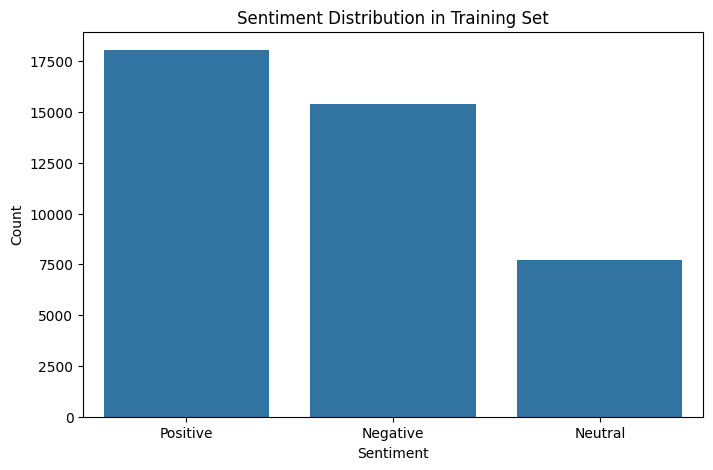


Test set sentiment distribution after mapping:
Sentiment
Negative    1633
Positive    1546
Neutral      619
Name: count, dtype: int64


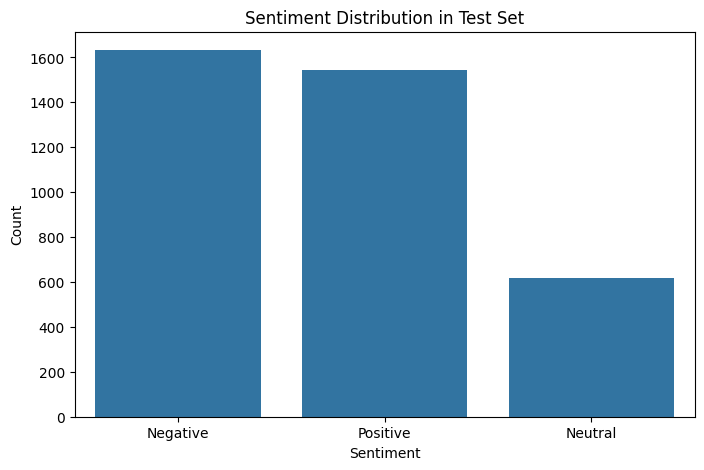

In [ ]:
print("After mapping:")
print(selected_features_train['Sentiment'].value_counts())
plt.figure(figsize=(8, 5))
sns.barplot(x=selected_features_train['Sentiment'].value_counts().index, y=selected_features_train['Sentiment'].value_counts().values)
plt.title('Sentiment Distribution in Training Set')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

print("\nTest set sentiment distribution after mapping:")
print(selected_features_test['Sentiment'].value_counts())
plt.figure(figsize=(8, 5))
sns.barplot(x=selected_features_test['Sentiment'].value_counts().index, y=selected_features_test['Sentiment'].value_counts().values)
plt.title('Sentiment Distribution in Test Set')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

### c) Lematizacija i čišćenje teksta

In [37]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [61]:
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
  tokens = word_tokenize(text)
  lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
  return " ".join(lemmatized)
  pass
selected_features_train['clean_tweet'] = selected_features_train['OriginalTweet'].apply(lemmatize_text).apply(clean_text)
selected_features_test['clean_tweet'] = selected_features_test['OriginalTweet'].apply(lemmatize_text).apply(clean_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### d) Pretvaranje teksta u vektore značajki (TF-IDF)

TF-IDF (Term Frequency–Inverse Document Frequency) je statistička metoda koja se koristi u obradi prirodnog jezika i pretraživanju informacija za procjenu koliko je određena riječ važna za jedan dokument u odnosu na veću zbirku dokumenata. TF-IDF kombinira dvije komponente:
1. Frekvencija pojma (TF): Mjeri koliko se puta riječ pojavljuje u dokumentu. Veća učestalost sugerira veću važnost. Ako se neki pojam često pojavljuje u dokumentu, vjerojatno je relevantan za sadržaj tog dokumenta.
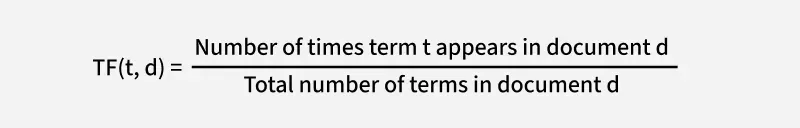

2. Obrnuta frekvencija dokumenta (IDF): Smanjuje težinu uobičajenih riječi koje se pojavljuju u više dokumenata, dok povećava težinu rijetkih riječi. Ako se pojam pojavljuje u manjem broju dokumenata, veća je vjerojatnost da je značajan i specifičan.
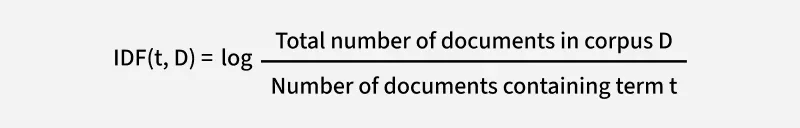

Ova ravnoteža omogućuje TF-IDF-u da istakne pojmove koji su i učestali unutar određenog dokumenta i prepoznatljivi u odnosu na ostatak zbirke dokumenata, što ga čini korisnim alatom za zadatke poput rangiranja pretraživanja, klasifikacije teksta i izdvajanja ključnih riječi.

In [67]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

X_train = tfidf.fit_transform(selected_features_train['clean_tweet'])
#ZADATAK: Transformirati očišćene tekstualne tweetove u numeričku TF-IDF reprezentaciju na testnom skupu.
X_test = tfidf.transform(selected_features_test['clean_tweet'])

### e) Enkodiranje oznaka

In [63]:
le = LabelEncoder()

print(selected_features_train['Sentiment'].unique())

y_train = le.fit_transform(selected_features_train['Sentiment'])
y_test = le.transform(selected_features_test['Sentiment'])

y_train = pd.DataFrame(y_train, columns=['Sentiment'])
y_test = pd.DataFrame(y_test, columns=['Sentiment'])
y_train.head()

['Neutral' 'Positive' 'Negative']


,Sentiment
0,1
1,2
2,2
3,2
4,0


## 4. Treniranje modela - Naive Bayes

In [64]:
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(MultinomialNB(), param_grid, cv=skf, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_)
print("Best cross-val accuracy:", grid.best_score_)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best alpha: {'alpha': 0.1}
Best cross-val accuracy: 0.6790584824797198


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [65]:
model = MultinomialNB(alpha = 0.1)
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=0.1)

## 5. Evaluacija performansi

In [68]:
y_pred = model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

    Negative       0.72      0.73      0.72      1633
     Neutral       0.64      0.21      0.31       619
    Positive       0.64      0.81      0.71      1546

    accuracy                           0.68      3798
   macro avg       0.67      0.58      0.58      3798
weighted avg       0.68      0.68      0.65      3798

Confusion Matrix:

[[1185   48  400]
 [ 185  129  305]
 [ 268   26 1252]]


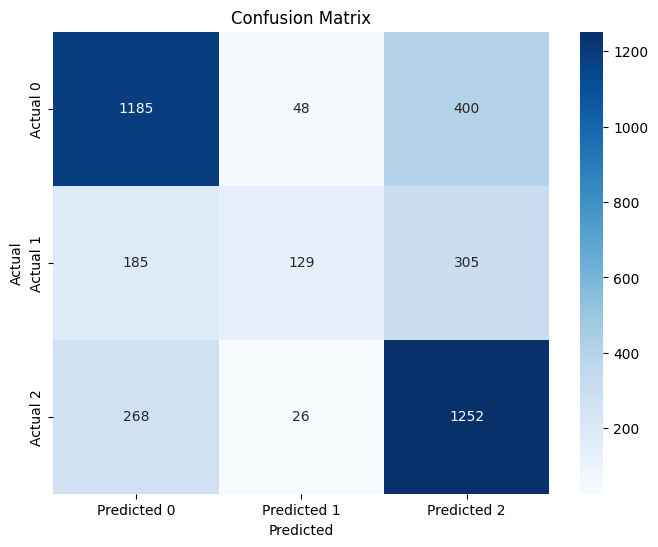

In [69]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2'],
            yticklabels=['Actual 0', 'Actual 1', 'Actual 2'])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## ZADATAK:
Trenirati model koristeći SVM i usporediti performanse s Naive Bayes-om.

In [70]:
svm = LinearSVC()
svm.fit(X_train, y_train)

svm_pred = svm.predict(X_test)

print("SVM Results:")
print("Accuracy:", accuracy_score(y_test, svm_pred))
print("F1 Score:", f1_score(y_test, svm_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, svm_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Results:
Accuracy: 0.7864665613480779
F1 Score: 0.785682612354007

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.80      1633
           1       0.68      0.64      0.66       619
           2       0.80      0.84      0.82      1546

    accuracy                           0.79      3798
   macro avg       0.76      0.76      0.76      3798
weighted avg       0.79      0.79      0.79      3798



# Zadatak – samostalan rad na datasetu

### U ovom zadatku studenti će sami proći cijeli proces klasifikacije teksta koristeći metode strojnog učenja – od pripreme podataka do treniranja i usporedbe različitih modela.

Cilj je klasificirati opise proizvoda iz e-trgovine u jednu od četiri kategorije (Electronics, Household, Books, Clothing & Accessories).

### Koraci zadatka:

1. **Pregled dataseta**  
   - Preuzmite dataset „E-commerce Text Classification“ s Kaggle-a:  
     https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification  
   - Učitajte ga u Colab (npr. pomoću `pd.read_csv`)  
   - Prikažite osnovne informacije o datasetu

2. **Odabir značajki i čišćenje podataka**  
   - Provjerite i obradite nedostajuće vrijednosti
   - Uklonite duplikate ako postoje  
   - Po potrebi uravnotežite dataset (npr. undersampling/oversampling) – nije obavezno, ali je plus

3. **Predobrada teksta (čišćenje i lematizacija)**  
   - Pretvorite tekst u mala slova  
   - Uklonite HTML tagove, URL-ove, interpunkciju, brojeve, specijalne znakove  
   - Uklonite stop-riječi  
   - Provedite lematizaciju

4. **Pretvaranje teksta u vektore značajki**  
     - `TfidfVectorizer`
   - Podijelite podatke na train/test skup (80/20 ili 75/25)

5. **Enkodiranje oznaka (labela)**  
   - Pretvorite tekstualne kategorije u brojčane pomoću `LabelEncoder` ili `OneHotEncoder` (ovisno o modelu)

6. **Treniranje i usporedba modela**  
   
   
   Za svaki model:
   - Naučite model na trening skupu
   - Izmjerite performanse na test skupu: **accuracy, precision, recall, F1-score**
   - Nacrtajte **confusion matrix** i **classification report**
   - Ako stignete: Podesite hiperparametre (barem `GridSearchCV` ili `RandomizedSearchCV` na 2–3 parametra) za bolje rezultate

7. **Vizualizacija rezultata**  
   - Usporedite dva (ili više) modela u tablici i stupčastim grafom (accuracy, F1-score)
   
   - Ako koristite TF-IDF, pokažite 10–20 riječi s najvećim TF-IDF težinama po klasi (Iz riječi biste trebali zaključiti o kojoj klasi se radi)

8. **Zaključak i komentar rezultata**  
   - Koji model je bio bolji i zašto?
   - Koje su prednosti i nedostaci pristupa koje ste koristili?
   - Što biste još mogli isprobati da poboljšate rezultat (ideje za daljnje eksperimente)?
   - Koliko je predobrada teksta utjecala na performanse?


In [48]:
import pandas as pd

data = pd.read_csv("/content/sample_data/ecommerceDataset.csv")

data.columns = ['category', 'text']
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50424 entries, 0 to 50423
Data columns (total 2 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

,Household,"Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal bliss.so bring home this elegant print that is lushed with rich colors that makes it nothing but sheer elegance to be to your friends and family.it would be treasured forever by whoever your lucky recipient is. Liven up your place with these intriguing paintings that are high definition hd graphic digital prints for home, office or any room."
count,50424,50423
unique,4,27801
top,Household,Think & Grow Rich About the Author NAPOLEON HI...
freq,19312,30


In [55]:
data.columns

Index(['Household', 'Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and s

In [51]:
data.isna().sum()

data = data.dropna()

data = data.drop_duplicates()

data.isna().sum()

,0
Household,0
"Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal bliss.so bring home this elegant print that is lushed with rich colors that makes it nothing but sheer elegance to be to your friends and family.it would be treasured forever by whoever your lucky recipient is. Liven up your place with these intriguing paintings that are high definition hd graphic digital prints for home, office or any room.",0


In [60]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('omw-1.4', quiet=True)

def preprocess_text(text):

    if not isinstance(text, str):
        return ""

    text = text.lower()

    # HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Email adrese
    text = re.sub(r'\S+@\S+', '', text)

    # Specijalni znakovi
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra whitespace
    #text = re.sub(r'\s+', ' ', text).strip()

    #brojevi
    text = re.sub(r'\d+', '', text)

    # Tokenize
    tokens = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join back into string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

print("\n=== Preprocessing Text ===")
data['cleaned_text'] = data['text'].apply(preprocess_text)

print("\nSample Results:")
for i in range(3):
    print(f"\nOriginal: {data.iloc[i]['text'][:200]}...")
    print(f"Cleaned: {data.iloc[i]['cleaned_text'][:200]}...")
    print(f"Category: {data.iloc[i]['category']}")
    print("-" * 80)

empty_count = (data['cleaned_text'].str.strip() == '').sum()
print(f"\nEmpty cleaned texts: {empty_count}")

if empty_count > 0:
    data = data[data['cleaned_text'].str.strip() != '']
    print(f"Removed {empty_count} empty rows. New shape: {data.shape}")

print("\n✓ Preprocessing complete!")


=== Preprocessing Text ===

Sample Results:

Original: SAF 'Floral' Framed Painting (Wood, 30 inch x 10 inch, Special Effect UV Print Textured, SAO297) Painting made up in synthetic frame with UV textured print which gives multi effects and attracts towar...
Cleaned: saf floral framed painting wood inch x inch special effect uv print textured sao painting made synthetic frame uv textured print give multi effect attracts towards special series painting make wall be...
Category: Household
--------------------------------------------------------------------------------

Original: SAF 'UV Textured Modern Art Print Framed' Painting (Synthetic, 35 cm x 50 cm x 3 cm, Set of 3) Color:Multicolor                                                                                 |       ...
Cleaned: saf uv textured modern art print framed painting synthetic cm x cm x cm set colormulticolor size cm x cm x cm overview beautiful painting involves action skill using paint right manner hence end produ..

In [75]:
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english'
)

X_tfidf = tfidf.fit_transform(data['cleaned_text'])

In [78]:
le = LabelEncoder()
y = le.fit_transform(data['category'])

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

print("Veličina trening skupa:", X_train.shape)
print("Veličina testnog skupa:", X_test.shape)

Veličina trening skupa: (22184, 5000)
Veličina testnog skupa: (5547, 5000)


In [80]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()


 Naive Bayes 
Accuracy: 0.9269875608436993
Precision: 0.9278018167785227
Recall: 0.9269875608436993
F1-score: 0.926917639831334

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      1242
           1       0.95      0.96      0.96      1132
           2       0.90      0.91      0.91      1061
           3       0.91      0.94      0.93      2112

    accuracy                           0.93      5547
   macro avg       0.93      0.92      0.93      5547
weighted avg       0.93      0.93      0.93      5547



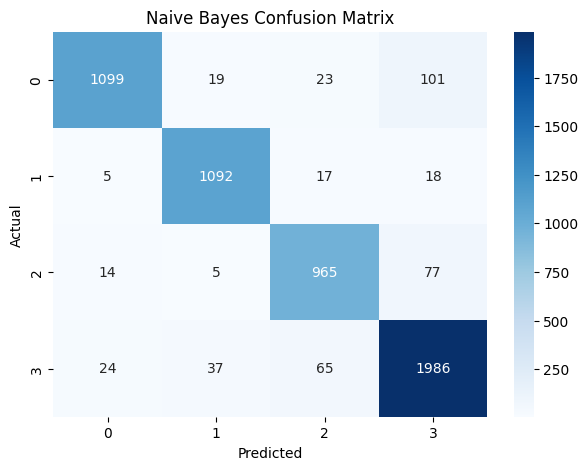

In [81]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

print(" Naive Bayes ")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes Confusion Matrix")


 SVM 
Accuracy: 0.9489814314043628
Precision: 0.9490904435677011
Recall: 0.9489814314043628
F1-score: 0.9489577635982013

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95      1242
           1       0.97      0.96      0.97      1132
           2       0.93      0.93      0.93      1061
           3       0.94      0.96      0.95      2112

    accuracy                           0.95      5547
   macro avg       0.95      0.95      0.95      5547
weighted avg       0.95      0.95      0.95      5547



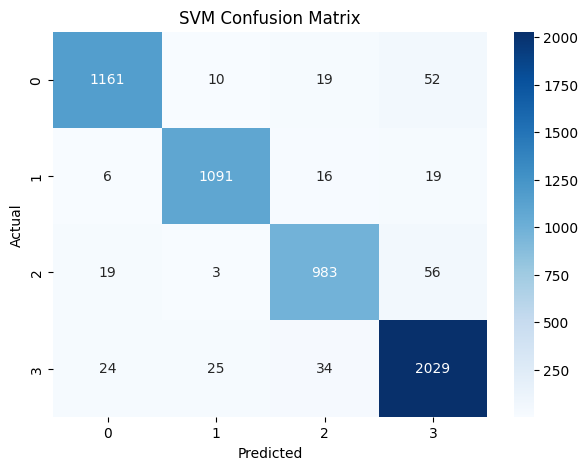

In [82]:
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print(" SVM ")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_svm, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred_svm, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

plot_confusion_matrix(y_test, y_pred_svm, "SVM Confusion Matrix")

Model Comparison:
         Model  Accuracy  F1-score
0  Naive Bayes  0.926988  0.926918
1          SVM  0.948981  0.948958


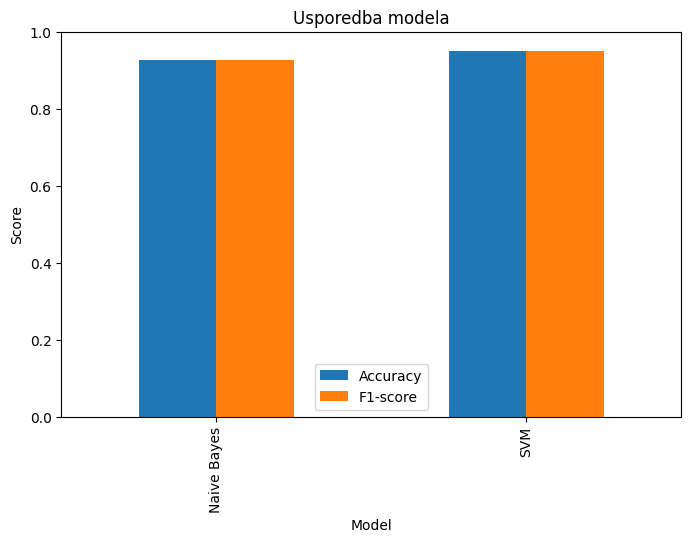

In [90]:
results = {
    'Model': ['Naive Bayes', 'SVM'],
    'Accuracy': [accuracy_score(y_test, y_pred_nb), accuracy_score(y_test, y_pred_svm)],
    'F1-score': [f1_score(y_test, y_pred_nb, average='weighted'), f1_score(y_test, y_pred_svm, average='weighted')]
}
results_df = pd.DataFrame(results)

print("Model Comparison:")
print(results_df)

results_df.plot(x='Model', y=['Accuracy','F1-score'], kind='bar', figsize=(8,5))
plt.title("Usporedba modela")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()

In [84]:
import numpy as np
X_tfidf_array = X_train.toarray()
feature_names = np.array(tfidf.get_feature_names_out())

for class_idx, class_name in enumerate(le.classes_):
    class_docs_idx = np.where(y_train == class_idx)[0]

    class_tfidf_mean = X_tfidf_array[class_docs_idx].mean(axis=0)

    top_n = 15
    top_indices = class_tfidf_mean.argsort()[::-1][:top_n]
    top_words = feature_names[top_indices]

    print(f"Top {top_n} riječi za klasu '{class_name}':")
    print(top_words)
    print("\n")

Top 15 riječi za klasu 'Books':
['book' 'author' 'review' 'university' 'student' 'new' 'life' 'world'
 'exam' 'year' 'story' 'science' 'india' 'guide' 'paper']


Top 15 riječi za klasu 'Clothing & Accessories':
['cotton' 'men' 'womens' 'wear' 'girl' 'fit' 'fabric' 'boy' 'look' 'woman'
 'size' 'pack' 'soft' 'comfort' 'sock']


Top 15 riječi za klasu 'Electronics':
['usb' 'camera' 'cable' 'speaker' 'black' 'mm' 'bluetooth' 'gb' 'phone'
 'device' 'laptop' 'audio' 'wireless' 'card' 'lens']


Top 15 riječi za klasu 'Household':
['set' 'steel' 'home' 'product' 'stainless' 'cm' 'table' 'easy' 'use'
 'color' 'kitchen' 'light' 'water' 'design' 'quality']




Zaključak:

Predobrada teksta (čišćenje, uklanjanje stop-riječi, lematizacija) značajno poboljšava performanse modela jer smanjuje šum i ujednačava riječi. TF-IDF vektorizacija omogućuje modelima da razumiju važnost riječi u dokumentu. Među modelima, SVM obično daje veću preciznost na složenijim skupovima podataka, dok je Naive Bayes brži i jednostavniji za tekstualne podatke. Odabir modela ovisi o veličini dataseta i zahtjevima za brzinu ili preciznost, a dodatna optimizacija hiperparametara može dodatno poboljšati rezultate.